![GEE_ML](./Images/GEE_ML_Hydrological_Cycle.JPG)

# Evaluating Hydrological Model Performance

In the previous two chapters, we learned how to retrieve
* catchment information using StreamStats
* streamflow observations from NWIS
* NLDAS remote sensing data products using Google Earth Engine

Using this data, we processed it into a daily temporal resolution dataframe that supported the training and optimization of an XGBoost machine learning model.
We trained a standard model on three years of the daily data (2020-2022) using a randomized train/test split of 66/33%, i.e., training the model on 66% of the data and evaluating model performance on the remaining 33%.
For model performance, we used the metrics of KGE, Percent Bias, Mean Absolute Percentage Error, and root-mean-squared-error.

We then used the GridSearch CV function to optimize the hyperparameters of the XGBoost algorithm, observing small improvements in model skill.

In this final lesson, we will combine the skills from the previous two to develop a model prediction workflow, as well as evaluate the prediction skill of the models to unseen data.

In [1]:
#Load necessary packages
from hydrotools.nwis_client.iv import IVDataService
from hydrotools.nwm_client import utils
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import Get_StreamStats
from scipy import optimize
from datetime import datetime, date
import pickle
import joblib
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

def NWIS_retrieve(site, startDT, endDT):
    service = IVDataService()
    usgs_data = service.get(
        sites=site,
        startDT= startDT,
        endDT= endDT
        )
    return usgs_data    

from platform import python_version

print(python_version())

C:\Users\rjohnson18\Anaconda3\envs\GEE_env\lib\site-packages\dataretrieval\nadp.py:44: UserWarning: GDAL not installed. Some functions will not work.
  warnings.warn('GDAL not installed. Some functions will not work.')


3.9.12


## Building the Prediction DataFrame
We will be making streamflow predictions for our test location of Red Butte Creek from the beginning of 2023 to present.
To do so, we need to load the stationary data (e.g., StreamStats) and retrieve NLDAS Precipitation and Temperature.
Let's develop the workflow

In [2]:
#Load StreamStats Dataframe from the Chapter 1
StreamStats = pd.read_csv('./Data/StreamStats1.csv')
#remove "Unamed: 0" column
StreamStats.pop('Unnamed: 0')

StreamStats

,NWIS_site_id,Lat,Long,Drainage_area_mi2,Mean_Basin_Elev_ft,Perc_Forest,Perc_Develop,Perc_Imperv,Perc_Herbace,Perc_Slop_30,Mean_Ann_Precip_in
0,10172200,40.779946,-111.806045,7.22,6810.0,43.1,0.0,0.00359,8.68,88.3,35.6


In [3]:
#Get NWIS observations for the new time period
start = '2023-1-1'
end = '2023-6-5'
NWISid = '10172200'

flow = NWIS_retrieve(NWISid, start, end)

#make the date the index for plotting and resampling
flow['datetime'] = flow['value_time']
flow.set_index('datetime', inplace = True)

#clean the data
flow = flow[flow['value'] > 0]

In [4]:
#Connect to Earth Engine to get NLDAS Temperature and Precipitation
import ee
import EE_funcs
ee.Authenticate()
ee.Initialize()

Enter verification code: 4/1AbUR2VN30LbVl-mKcSNCy9GHtzV8kM9JnTlbJvvgBJOHsUZgIC_ZMnmk0cc

Successfully saved authorization token.


In [5]:
#NLDAS temperature
print('Retrieving NLDAS Temperature and Precipitation from GEE')
temp = ee.ImageCollection('NASA/NLDAS/FORA0125_H002').select('temperature').filterDate(start, end)

#NLDAS precipitation
precip = ee.ImageCollection('NASA/NLDAS/FORA0125_H002').select('total_precipitation').filterDate(start, end)

# Define slc location of interest, lets use the USGS guage location!
lon = StreamStats['Long'][0]
lat = StreamStats['Lat'][0]
poi = ee.Geometry.Point(lon, lat)

scale = 1000  # scale in meters

# Get the data for the pixel intersecting the point at Red Butte Creek.
print('Retrieving NLDAS Temperature and Precipitation for desired location(s) ')
temp_poi = temp.getRegion(poi, scale).getInfo()
precip_poi = precip.getRegion(poi, scale).getInfo()

#Convert pointer object array to dataframe to work with
print('Converting object to DataFrame')
temp_RB = EE_funcs.ee_array_to_df(temp_poi,['temperature'])
precip_RB = EE_funcs.ee_array_to_df(precip_poi,['total_precipitation'])

Retrieving NLDAS Temperature and Precipitation from GEE
Retrieving NLDAS Temperature and Precipitation for desired location(s) 
Converting object to DataFrame


In [6]:
temp_RB

,time,datetime,temperature
0,1672531200000,2023-01-01 00:00:00,0.380000
1,1672534800000,2023-01-01 01:00:00,0.190039
2,1672538400000,2023-01-01 02:00:00,0.000000
3,1672542000000,2023-01-01 03:00:00,-0.190000
4,1672545600000,2023-01-01 04:00:00,-0.320000
...,...,...,...
3656,1685692800000,2023-06-02 08:00:00,12.110000
3657,1685696400000,2023-06-02 09:00:00,11.670000
3658,1685700000000,2023-06-02 10:00:00,11.160000
3659,1685703600000,2023-06-02 11:00:00,10.640000


In [7]:
precip_RB

,time,datetime,total_precipitation
0,1672531200000,2023-01-01 00:00:00,0.1476
1,1672534800000,2023-01-01 01:00:00,0.1476
2,1672538400000,2023-01-01 02:00:00,0.2444
3,1672542000000,2023-01-01 03:00:00,0.1480
4,1672545600000,2023-01-01 04:00:00,0.1992
...,...,...,...
3656,1685692800000,2023-06-02 08:00:00,0.0000
3657,1685696400000,2023-06-02 09:00:00,0.0000
3658,1685700000000,2023-06-02 10:00:00,0.0000
3659,1685703600000,2023-06-02 11:00:00,0.0000


In [8]:
#resample to the desired temporal scale, take the respective statistic from the data of resampling
temporal_resample = 'D'
kg_in = 0.04

#Temperature
temp_RB.set_index('datetime', inplace = True)
temp_RB = temp_RB.resample(temporal_resample).max()
temp_RB.reset_index(inplace = True)

#Precipitation
precip_RB.set_index('datetime', inplace = True)
precip_RB = precip_RB.resample(temporal_resample).sum()
precip_RB.reset_index(inplace = True)

#make columns for Fahrenheit
temp_RB['temperature_F'] = (temp_RB['temperature']*9/5)+32 

#make columns for inches
precip_RB['precipitation_in'] = precip_RB['total_precipitation']*kg_in

#need to add in time to precip data, same daterange as temperaure
precip_RB['time'] = temp_RB['time']

#ensure columns are in the correct order
colorder = ['datetime', 'time', 'total_precipitation', 'precipitation_in']
precip_RB = precip_RB[colorder]

## Create a DataFrame for input into ML model

We have looked at daily resolution temperature and precipitation, so lets stay at this resolution. 
The NLDAS data is available at 1 hr temporal resolution with the ability to resample to an greater timestep using the [resample](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.resample.html) function.

The [Merge, Join, Concatenate and Compare](https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html) functions will be most useful here.

In [9]:
#Lets begin with the temperature and precipitation data
Pred_DF = temp_RB.copy()

#remote unnecessary columns, time, temperature
colrem = ['time', 'temperature']
Pred_DF.drop(colrem, axis =1, inplace =True)

#lets add the precipitation data
Pred_DF['precipitation_in'] = precip_RB['precipitation_in']

#set index to datetime
Pred_DF.set_index('datetime', drop = True, inplace = True)

#lets add streamflow, but we need to make it at the same temporal resolution (daily)
cols = ['value']
flow = flow[cols]
flow = flow.resample(temporal_resample).mean()
flow.rename(columns ={'value':'flow_cfs'}, inplace = True)

#concat dataframe by date
Pred_DF = pd.concat([Pred_DF, flow], axis = 1).dropna()

#Add the NWIS id to match with StreamStats
Pred_DF['NWIS_site_id'] = NWISid
#convert object to int64 to match StreamStats
Pred_DF['NWIS_site_id'] = Pred_DF['NWIS_site_id'].astype('int64')

In [10]:
#Lets join the StreamStats Features, we can merge by NWIS_site_id
DF = Pred_DF.join(StreamStats.set_index("NWIS_site_id"), on="NWIS_site_id")

#reset the index
DF.reset_index(inplace = True)

#Remove NWIS_site_id
DF.pop('NWIS_site_id')

#Add Day of year (DOY)
DF['DOY'] = DF.datetime.dt.dayofyear

#remove old datetime column
DF.pop('datetime')

#save DataFrame for Model Development
DF.to_csv('./Data/Pred_DF1.csv')

In [11]:
DF

,temperature_F,precipitation_in,flow_cfs,Lat,Long,Drainage_area_mi2,Mean_Basin_Elev_ft,Perc_Forest,Perc_Develop,Perc_Imperv,Perc_Herbace,Perc_Slop_30,Mean_Ann_Precip_in,DOY
0,32.68400,0.806648,1.245435,40.779946,-111.806045,7.22,6810.0,43.1,0.0,0.00359,8.68,88.3,35.6,1
1,29.06607,0.191600,1.170000,40.779946,-111.806045,7.22,6810.0,43.1,0.0,0.00359,8.68,88.3,35.6,2
2,27.06800,0.069568,1.125729,40.779946,-111.806045,7.22,6810.0,43.1,0.0,0.00359,8.68,88.3,35.6,3
3,32.90000,0.000224,1.120000,40.779946,-111.806045,7.22,6810.0,43.1,0.0,0.00359,8.68,88.3,35.6,4
4,39.30800,0.022680,1.115000,40.779946,-111.806045,7.22,6810.0,43.1,0.0,0.00359,8.68,88.3,35.6,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,71.61800,0.024672,15.794791,40.779946,-111.806045,7.22,6810.0,43.1,0.0,0.00359,8.68,88.3,35.6,149
146,72.87800,0.000000,15.151042,40.779946,-111.806045,7.22,6810.0,43.1,0.0,0.00359,8.68,88.3,35.6,150
147,74.13800,0.000000,14.566667,40.779946,-111.806045,7.22,6810.0,43.1,0.0,0.00359,8.68,88.3,35.6,151
148,73.34600,0.011776,13.992708,40.779946,-111.806045,7.22,6810.0,43.1,0.0,0.00359,8.68,88.3,35.6,152


## Scale the DataFrame and make predictions

Set up the DataFrame for predictions, i.e., remote flow observations and scale the model input variables.

In [12]:
#Split the data into features and target
y = DF['flow_cfs']

#remove target from features
DF.pop('flow_cfs')

X = DF

#scale the predictor inputs
#load the scalers
scaler_x = pickle.load(open('./Model/XGBoost/scaler_x1.pkl', 'rb'))
scaler_y = pickle.load(open('./Model/XGBoost/scaler_y1.pkl', 'rb'))

#apply the scaler to the X_testing data
X_scaled = scaler_x.transform(X)

#Load the original model
model = pickle.load(open('./Model/XGBoost/Model_1.dat', "rb"))

# make a prediction
y_pred = model.predict(X_scaled)
    
#scale the predictions back to streamflow in cfs and convert to pandas DataFrame
y_pred = pd.DataFrame(scaler_y.inverse_transform(pd.DataFrame(y_pred)),columns = ['flow_cfs_pred'])
y = pd.DataFrame(y, columns = ['flow_cfs'])

#Load the optimized model, remember to change it ot the correction one!
model = pickle.load(open('./Model/XGBoost/Model_HyperParam.dat', "rb"))

# make a prediction
y_pred_Hyp = model.predict(X_scaled)
    
#scale the predictions back to streamflow in cfs and convert to pandas DataFrame
y_pred_Hyp = pd.DataFrame(scaler_y.inverse_transform(pd.DataFrame(y_pred_Hyp)),columns = ['flow_cfs_Hyp_pred'])


#Combine X_test, y_pred, and y_test DataFrames to evaluate the performance of the model
#reset indexes
DFs = [y_pred_Hyp, y_pred, y, X]
for df in DFs:
    df.reset_index(drop = True, inplace = True)
    
#merge
Eval_DF = pd.concat(DFs, axis=1)

Eval_DF
    
#merge
Eval_DF = pd.concat(DFs, axis=1)

Eval_DF

,flow_cfs_Hyp_pred,flow_cfs_pred,flow_cfs,temperature_F,precipitation_in,Lat,Long,Drainage_area_mi2,Mean_Basin_Elev_ft,Perc_Forest,Perc_Develop,Perc_Imperv,Perc_Herbace,Perc_Slop_30,Mean_Ann_Precip_in,DOY
0,1.375064,1.697332,1.245435,32.68400,0.806648,40.779946,-111.806045,7.22,6810.0,43.1,0.0,0.00359,8.68,88.3,35.6,1
1,1.342672,1.524061,1.170000,29.06607,0.191600,40.779946,-111.806045,7.22,6810.0,43.1,0.0,0.00359,8.68,88.3,35.6,2
2,1.329615,1.375173,1.125729,27.06800,0.069568,40.779946,-111.806045,7.22,6810.0,43.1,0.0,0.00359,8.68,88.3,35.6,3
3,1.293538,1.082169,1.120000,32.90000,0.000224,40.779946,-111.806045,7.22,6810.0,43.1,0.0,0.00359,8.68,88.3,35.6,4
4,1.544214,1.297445,1.115000,39.30800,0.022680,40.779946,-111.806045,7.22,6810.0,43.1,0.0,0.00359,8.68,88.3,35.6,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,2.285049,2.317530,15.794791,71.61800,0.024672,40.779946,-111.806045,7.22,6810.0,43.1,0.0,0.00359,8.68,88.3,35.6,149
146,2.172579,1.604797,15.151042,72.87800,0.000000,40.779946,-111.806045,7.22,6810.0,43.1,0.0,0.00359,8.68,88.3,35.6,150
147,2.217271,1.284092,14.566667,74.13800,0.000000,40.779946,-111.806045,7.22,6810.0,43.1,0.0,0.00359,8.68,88.3,35.6,151
148,2.171122,2.280818,13.992708,73.34600,0.011776,40.779946,-111.806045,7.22,6810.0,43.1,0.0,0.00359,8.68,88.3,35.6,152


## Comparision of hydrological models

We can find the evaluation functions from Chapter 2 in the Evaluation_funcs.py file and import them in the interactive python file to A) clean up our notebook and B) evaluate the performance of different models.

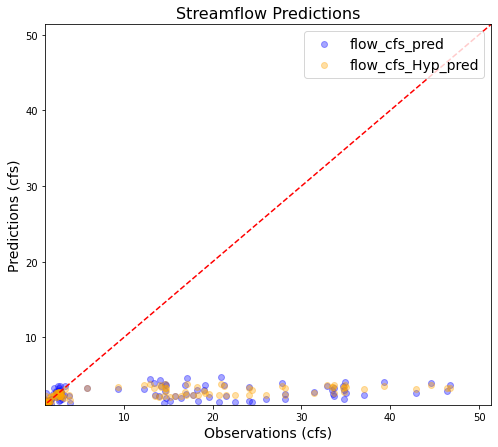

RMSE for  flow_cfs_pred  is  14.102053  cfs
RMSE for  flow_cfs_Hyp_pred  is  13.998855  cfs
Mean Absolute Percentage Error for  flow_cfs_pred  is  42.61 %
Mean Absolute Percentage Error for  flow_cfs_Hyp_pred  is  41.59 %
Percentage Bias for  flow_cfs_pred  is  78.32 %
Percentage Bias for  flow_cfs_Hyp_pred  is  77.55 %
Kling-Glutz Efficiency for  flow_cfs_pred  is  -0.29
Kling-Glutz Efficiency for  flow_cfs_Hyp_pred  is  -0.24


In [13]:
import Evaluation_funcs

#Evaluate model performance of the different models
prediction_columns = ['flow_cfs_pred', 'flow_cfs_Hyp_pred']

#plot the predictions
Evaluation_funcs.Model_Evaluation_Plots(Eval_DF, prediction_columns)

#Get RMSE from the model
Evaluation_funcs.RMSE(Eval_DF, prediction_columns)

#Get Mean Absolute Percentage Error from the model
Evaluation_funcs.MAPE(Eval_DF, prediction_columns)

#Get Percent Bias from the model
Evaluation_funcs.PBias(Eval_DF, prediction_columns)

#Get Kling-Gutz Efficiency from the model
Evaluation_funcs.KGE(Eval_DF, prediction_columns)

## That was not the model performance we were expecting
Let's investigate!

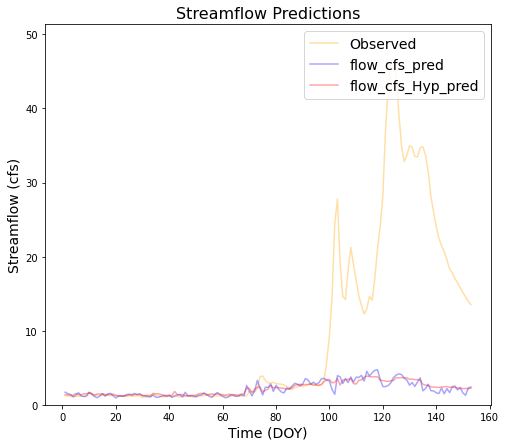

In [39]:
Evaluation_funcs.Hydrograph_Evaluation_Plots(Eval_DF, prediction_columns)

## Why is the model not capturing the high flow rates?
Did we miss something in the training data?

Lets look at the hydrograph from the training data to see if we can identify a reason for the poor predictions.

In [43]:
#Get NWIS observations for the new time period
start = '2021-1-1'
end = '2022-12-31'
NWISid = '10172200'

flow = NWIS_retrieve(NWISid, start, end)

#make the date the index for plotting and resampling
flow['datetime'] = flow['value_time']
flow.set_index('datetime', inplace = True)

#clean the data
flow = flow[flow['value'] > 0]

#resample to daily resolution
flow.rename(columns={'value':'flow_cfs'}, inplace = True)
flow = pd.DataFrame(flow['flow_cfs'])
flow = flow.resample(temporal_resample).mean()

flow

,flow_cfs
datetime,
2021-01-01,1.022609
2021-01-02,1.020000
2021-01-03,1.026146
2021-01-04,1.033021
2021-01-05,1.080000
...,...
2022-12-27,1.100500
2022-12-28,1.337188
2022-12-29,1.141875


In [44]:
# Plot the Hydrograph
def hydrograph_plot(DF, flow):
    fig, ax = plt.subplots(1,1, figsize=(8, 7))
    fig.patch.set_facecolor('white')

    #set min/max for y-axis of the predictions/observations
    ymin = min(DF['flow_cfs'])*1.1
    ymax = max(DF['flow_cfs'])*1.1


    ax.plot(DF.index, DF['flow_cfs'],
                   c='orange', label= 'Observed Streamflow')

     # Add some parameters.
    ax.set_title('Hydrograph', fontsize=16)
    ax.set_xlabel('Time (DOY)', fontsize=14)
    ax.set_ylabel('Streamflow (cfs)', fontsize=14,)
    ax.set_ylim(0, ymax)
    ax.legend(fontsize=14, loc='upper right')

    plt.show()

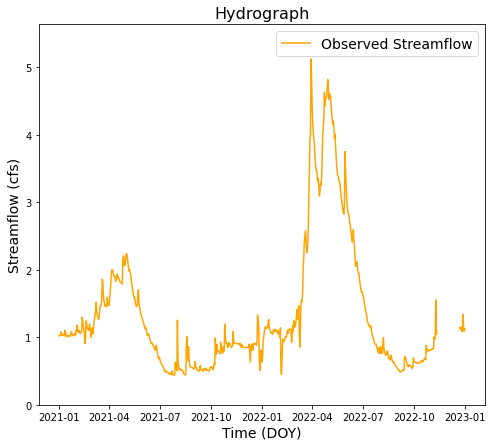

In [45]:
hydrograph_plot(flow, 'flow_cfs')

## Are there any significant differences between the flow observations used in training vs. the 2023 water year?


## Exercise
We applied the GEE-ML model workflow to one stream. Apply the workflow to the ML model you developed in the previous chapter's exercise. 
How did you model perform?
